# Getting started

To get started with running on Colab, run the following script after changing CURRENT_DIR to the correct path to the project folder. **Note**: Colab does not fully support interactive Matplotlib plots, so some functions like loss visualisation during training may not work fully.

In [ ]:
# If running on Colab
%matplotlib inline

CURRENT_DIR = '/content/drive/My Drive/Classes/CS5242 project'

from google.colab import drive
drive.mount("/content/drive")

If running the notebook locally (e.g. Jupyter or Jupyter Labs), run the following script instead.

In [1]:
# If running locally
# %matplotlib notebook
%matplotlib inline

CURRENT_DIR = '.'

Run the following script regardless of whether you are running locally or on Colab, to set up your paths.

In [2]:
import os
import sys
os.chdir(CURRENT_DIR)
sys.path.append(CURRENT_DIR)
print(os.getcwd())

import utils

/home/adacomp/work/CS5242-neural-motion-planning


# Data generation

## Environment and robot

Our robot is a shaped as a 2d planar box with size equals to 0.2 meters. It can move simultaneously both horizontally and vertically. Therefore, its configuration space is a 2d rectangle which size is determined by the maze size. 

In [3]:
class MyPlanarRobot():
    def __init__(self, base_xy_bounds=5.0) -> None:
        self.num_dim = 2
        self.joint_idx=[0,1]
        self.size = 0.2

        self.joint_bounds = []
        self.joint_bounds.append([-base_xy_bounds, base_xy_bounds]) # x
        self.joint_bounds.append([-base_xy_bounds, base_xy_bounds]) # y

        self.reset()

    def get_joint_bounds(self):
        return self.joint_bounds

    def get_joint_lower_bounds(self):
        robot_bounds_low = [bound[0] for bound in self.joint_bounds]
        return robot_bounds_low

    def get_joint_higher_bounds(self):
        robot_bounds_high = [bound[1] for bound in self.joint_bounds]
        return robot_bounds_high

    def get_cur_state(self):
        return self.state

    def set_state(self, state):
        self.state = state

    def reset(self):
        self.state = [0] * self.num_dim

Our environment is a 2d maze with size 5m * 5m. It is filled with random generated square obstacles of fixed size 1m * 1m.  The difficulties of the maze can be manipulated by altering the number of obstacles present. The maze can be visualized by an occupancy grid with resolution 0.5m, making it essentially an image of size 10 x 10. 

To facilitate path planning, the maze class also contains code to sample valid start and goals of the point robot and perform collision checking for a given robot configuration. 

In [4]:
import os
import sys
import numpy as np
import math
import random
import json
import sys
import os.path as osp

# -------------- Settings ----------------
RANDOM = True
TOTAL_START_GOAL_CNT = 50
MAZE_SIZE = 5
OCC_GRID_RESOLUTION = 0.1
SMALL_OCC_GRID_RESLUTION = 0.5

class Maze2D():
    def __init__(self):
        self.obstacles = []

        # load robot
        robot = MyPlanarRobot(base_xy_bounds = MAZE_SIZE / 2.0)
        self.robot = robot

        # 2d occupancy grid
        self.occ_grid_size = int(MAZE_SIZE / OCC_GRID_RESOLUTION)
        self.occ_grid = np.zeros((self.occ_grid_size, self.occ_grid_size), dtype=np.uint8)
        self.small_occ_grid_size = int(MAZE_SIZE / SMALL_OCC_GRID_RESLUTION)

        # clear obstacles
        self.clear_obstacles()

        # add surrounding walls
        half_size = MAZE_SIZE / 2.0
        # add wall
        self.add_box([half_size + 0.1, 0, 1], [0.1, half_size, 1])
        self.add_box([-half_size - 0.1, 0, 1], [0.1, half_size, 1])
        self.add_box([0, half_size + 0.1, 1], [half_size, 0.1, 1])
        self.add_box([0, -half_size - 0.1, 1], [half_size, 0.1, 1])

        # internal attributes
        self.goal_robot_id = None
        self.path = None
        self.approx_path = None
        self.sg_pairs = None

    def clear_obstacles(self):
        self.occ_grid.fill(0)
        self.obstacle_dict = {}
        self.inflated_occ_grid = None

    def random_obstacles(self, num_of_boxes = 8):
        # add random obstacles with boxes.
        # box_positions = [(-2.25, 2.25)]
        box_positions = []

        for _ in range(num_of_boxes):
            x = random.randint(0, 4)
            y = random.randint(0, 4)
            x = x - 2
            y = y - 2
            box_positions.append((x, y))

        # print(box_positions)
        for box_pos in box_positions:
            self.add_box([box_pos[0], box_pos[1], 0.5], [0.5, 0.5, 0.5])

        self.obstacle_dict["box"] = box_positions
        self.get_inflated_occ_grid()

    def add_box(self, box_pos, half_box_size):
        # for occupancy grid, center is at upper left corner, unit is cm
        half_size = MAZE_SIZE / 2.0
        tmp = int(1 / OCC_GRID_RESOLUTION)
        cx = (-box_pos[1] + half_size) * tmp
        cy = (box_pos[0] + half_size) * tmp
        x_size = half_box_size[1] * tmp
        y_size = half_box_size[0] * tmp
        for x in range(max(0, int(cx - x_size)), min(self.occ_grid_size, int(cx + x_size))):
            for y in range(max(0, int(cy - y_size)), min(self.occ_grid_size, int(cy + y_size))):
                self.occ_grid[x, y] = 1

    def get_occupancy_grid(self):
        return self.occ_grid

    def get_small_occupancy_grid(self):
        occ_grid_small = np.zeros((self.small_occ_grid_size, self.small_occ_grid_size), dtype=np.int8)
        for i in range(self.small_occ_grid_size):
            for j in range(self.small_occ_grid_size):
                occ_grid_small[i, j] = (np.max(self.occ_grid[i*5:(i+1)*5, j*5:(j+1)*5]) == 1)
        return occ_grid_small

    def get_obstacle_dict(self):
        return self.obstacle_dict.copy()

    def load_obstacle_dict(self, obstacle_dict):
        if "box" in obstacle_dict:
            for box_pos in obstacle_dict["box"]:
                self.add_box([box_pos[0], box_pos[1], 0.5], [0.5, 0.5, 0.5])

        self.obstacle_dict = obstacle_dict
        
    @classmethod
    def load_small_occupancy_grid(cls, small_occ_grid):
        maze = cls()
        maze.occ_grid = np.zeros((maze.occ_grid_size, maze.occ_grid_size), dtype=np.uint8)
        if len(small_occ_grid) != maze.small_occ_grid_size * maze.small_occ_grid_size:
            raise RuntimeError("Input occupancy grid does not match hardcoded maze size!")
        
        small_occ_grid = np.array(small_occ_grid).astype(np.int8).reshape(maze.small_occ_grid_size, -1)
        for i in range(maze.small_occ_grid_size):
            for j in range(maze.small_occ_grid_size):
                if small_occ_grid[i, j] == 1:                    
                    maze.occ_grid[i*5:(i+1)*5, j*5:(j+1)*5] = np.ones((5, 5), dtype=np.uint8)
        return maze

    def sample_start_goal(self):
        while True:
            start = [0] * self.robot.num_dim
            goal = [0] * self.robot.num_dim
            low_bounds = self.robot.get_joint_lower_bounds()
            high_bounds = self.robot.get_joint_higher_bounds()
            for i in range(self.robot.num_dim):
                start[i] = random.uniform(low_bounds[i], high_bounds[i])
                goal[i] = random.uniform(low_bounds[i], high_bounds[i])

            if self.is_state_valid(start) and self.is_state_valid(goal):
                self.start = start
                self.goal = goal
                break

        print("Maze2d: start: {}".format(self.start))
        print("Maze2d: goal: {}".format(self.goal))

    def get_inflated_occ_grid(self):
        if self.inflated_occ_grid is None:
            tmp = np.zeros((self.occ_grid_size + 2, self.occ_grid_size + 2), dtype=np.uint8)
            tmp[:self.occ_grid_size, :self.occ_grid_size] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, :self.occ_grid_size] += self.occ_grid
            tmp[2:, :self.occ_grid_size] += self.occ_grid
            tmp[:self.occ_grid_size, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[2:, 1:self.occ_grid_size+1] += self.occ_grid
            tmp[:self.occ_grid_size, 2:] += self.occ_grid
            tmp[1:self.occ_grid_size + 1, 2:] += self.occ_grid
            tmp[2:, 2:] += self.occ_grid
            tmp[tmp > 0] = 1

            self.inflated_occ_grid = tmp[1:self.occ_grid_size + 1, 1:self.occ_grid_size + 1]

    def is_state_valid(self, robot_state):
        # Inflate obstacle for collision checking
        self.get_inflated_occ_grid()

        y, x = robot_state[0], robot_state[1]
        x = int((MAZE_SIZE / 2.0 - x) / 0.1)
        y = int((y + MAZE_SIZE / 2.0) / 0.1)
    
        if 0 <= x and x < self.inflated_occ_grid.shape[0] and 0 <= y and y < self.inflated_occ_grid.shape[1]:
            return (self.inflated_occ_grid[x, y] != 1)
        else:
            return False

Let's generate a random environment and sample a random start and goal configuration of the robot and visualize the problem. The start configuration is shown in yellow and the goal configuration is shown in red.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_data(occ_g, start_pos, goal_pos, path, predicted_path=None):
    occ_g = np.array(occ_g).reshape(10, 10)
    fig, ax = plt.subplots(1, figsize=(10, 10), dpi=100)
    occ_grid_size = occ_g.shape[0]
    tmp = occ_grid_size / 4.0 - 0.25
    s = (10.0 / occ_grid_size * 100 / 2) ** 2 + 500
    for i in range(occ_grid_size):
        for j in range(occ_grid_size):
            if occ_g[i,j] == 1:
                plt.scatter(j/2.0 - tmp, tmp - i/2.0, color="black", marker='s', s=s, alpha=1) # init

    ax.add_patch(patches.Rectangle((start_pos[0]-0.1, start_pos[1]-0.1), 0.2, 0.2, facecolor='y'))
    ax.add_patch(patches.Rectangle((goal_pos[0]-0.1, goal_pos[1]-0.1), 0.2, 0.2, facecolor='r'))
    for i, next_pos in enumerate(path):
        ax.text(next_pos[0]+0.06, next_pos[1]+0.06, str(i), {'color': 'g', 'size': 'large'})
        ax.add_patch(patches.Rectangle((next_pos[0]-0.07, next_pos[1]-0.07), 0.14, 0.14, facecolor='g'))
    if predicted_path is not None:
        for i, predicted_pos in enumerate(predicted_path):
            ax.text(predicted_pos[0] - 0.11, predicted_pos[1] - 0.11, str(i), {'color': 'b', 'size': 'large'})
            ax.add_patch(patches.Rectangle((predicted_pos[0]-0.05, predicted_pos[1]-0.05), 0.1, 0.1, facecolor='b'))

    ax.set_title("Visualization")
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(-2.5,2.5)

Maze2d: start: [1.8566703787416037, -1.8728201875104578]
Maze2d: goal: [-1.626927285001859, 2.497159602154314]


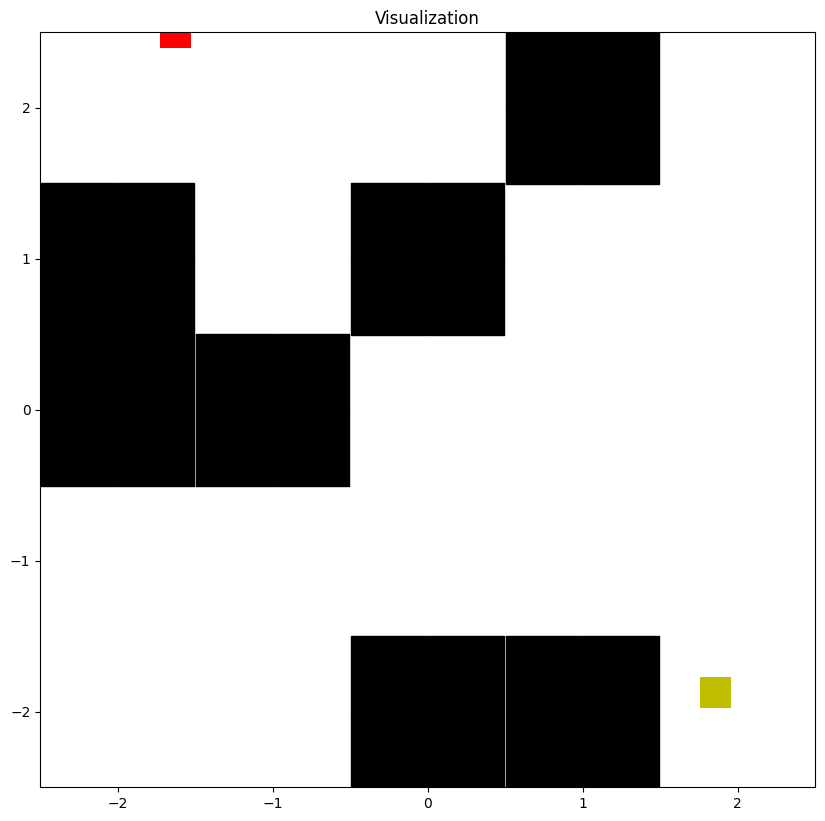

In [6]:
maze = Maze2D()
maze.random_obstacles()
maze.sample_start_goal()

occ_grid = maze.get_small_occupancy_grid()
visualize_data(occ_grid, maze.start, maze.goal, []) # Just visualise the environment for now, without any expert paths

## Generate Data from Expert Path Planner

To train a neural path planner, we need to generate a database of path planned by an expert path planner. There are numerous choices of path planners we can use. In this particular case, since our robot state is continuous, we choose to use the classic PRM motion planner. It firstly samples valid configurations of robot uniformly in the whole space and attempts to connect those configurations if the path between the states are collision-free. It results in a dense roadmap that captures the connectivity of the space. Finally, a discrete motion planner such as A* is used to find a path between a given start and goal configurations in the space. Another reason that PRM is particularly useful here is that it is multi-query planner, meaning the generated roadmap can be used to solve multiple queries of different start and goal configurations. 

To generate our path dataset, we sample 200 different mazes with number of obstacles ranging from 5 to 14. In each environment, we sample 500 random configurations and attempt to connect all valid configurations. We save the resultant roadmap as a networkx graph. 

### Generate Environments

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import itertools
import random
import utils


def create_environments(root_dir='./dataset', env_num=0, dense_num=500):
    if env_num == 0:
        return
    maze = Maze2D()
    for i in range(env_num):
        # save
        directory = osp.join(root_dir, str(i))
        if not osp.exists(directory):
            os.makedirs(directory)

        num_of_boxes = 5 + i // 50

        # env
        maze.clear_obstacles()
        maze.random_obstacles(num_of_boxes=num_of_boxes)
        occ_grid = np.array(maze.get_occupancy_grid()).reshape(50, 50)
        occ_grid_small = maze.get_small_occupancy_grid()
        obstacle_dict = maze.get_obstacle_dict()
        maze.sample_start_goal()
        maze.robot.set_state(maze.start)

        # dense states
        states = []
        col_status = []
        low = maze.robot.get_joint_lower_bounds()
        high = maze.robot.get_joint_higher_bounds()
        for _ in range(dense_num):
            random_state = [0] * maze.robot.num_dim
            for i in range(maze.robot.num_dim):
                random_state[i] = random.uniform(low[i], high[i])
            col_status.append(maze.is_state_valid(random_state)) # mark collision states
            states.append(random_state)

        dense_G = nx.DiGraph()
        dense_G.add_nodes_from([("n{}".format(i), {"coords": ','.join(map(str, state)), "col": not col_status[i]}) for i, state in enumerate(states)])

        # save
        # node_pos = np.array(states)
        node_pos = np.array([utils.state_to_numpy(dense_G.nodes[node]['coords']) for node in dense_G.nodes()])
        utils.visualize_nodes(occ_grid_small, node_pos, None, None, show=False, save=True, file_name=osp.join(directory, "dense.png"))
        node_pos = np.array([utils.state_to_numpy(dense_G.nodes[node]['coords']) for node in dense_G.nodes() if not dense_G.nodes[node]['col']])
        utils.visualize_nodes(occ_grid_small, node_pos, None, None, show=False, save=True, file_name=osp.join(directory, "dense_free.png"))

        print("connecting dense graph")
        nodes = dense_G.nodes()
        node_pairs = itertools.combinations(nodes, 2)
        # print(list(node_pairs))
        for node_pair in node_pairs:
            if not dense_G.has_edge(node_pair[0], node_pair[1]):
                s1 = dense_G.nodes[node_pair[0]]['coords']
                s2 = dense_G.nodes[node_pair[1]]['coords']
                if utils.is_edge_free(maze, s1, s2):
                    dense_G.add_edge(node_pair[0], node_pair[1])
                    dense_G.add_edge(node_pair[1], node_pair[0])
        for u,v in dense_G.edges:
            dense_G[u][v]['weight'] = utils.calc_weight_states(dense_G.nodes[u]['coords'], dense_G.nodes[v]['coords'])

        # save
        nx.write_graphml(dense_G, osp.join(directory, "dense_g.graphml"))
        with open(osp.join(directory, "occ_grid.txt"), 'w') as f:
            np.savetxt(f, occ_grid_small.reshape(1, -1))
        with open(osp.join(directory, "obstacle_dict.json"), 'w') as f:
            json.dump(obstacle_dict, f)
        utils.visualize_nodes(occ_grid_small, [], None, None, show=False, save=True, file_name=osp.join(directory, "occ_grid.png"))

In [ ]:
create_environments(root_dir='./test_dataset', env_num=5)

### Generate Path

We want to collect multiple paths from a single generated environment. Therefore, we first load the saved roadmap graph, and subsequently nvoke Astar path planner to find shortest path between each possible pair of start and goal configurations. If a path is found, we add to our dataset.

Here we ignore path that contains only 2 waypoints. Intuitively, a path with two waypoints means that the start configuration and goal configuration of the robot can be connected by a straigh line. As our environment is not very cluttered, the majority of the path in our dataset may constitute such a straight-line path. This imbalance might incur problems in the latter training stage. 

In [ ]:
import os.path as osp
import sys
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import utils

import astar

def generate_path(root_dir='./dataset', env_num=0, sample_num=500):
    if env_num == 0:
        return
    print(f'Generating path for data in {root_dir}')
    maze = Maze2D()

    dataset = []
    for i in range(env_num):
        print("generating paths in env {}".format(i))
        maze.clear_obstacles()
        
        data_dir = osp.join(root_dir, str(i))
        with open(osp.join(data_dir, "obstacle_dict.json"), 'r') as f:
            obstacle_dict = json.load(f)
            maze.load_obstacle_dict(obstacle_dict)

        dense_G = nx.read_graphml(osp.join(data_dir, "dense_g.graphml"))
        occ_grid = np.loadtxt(osp.join(data_dir, "occ_grid.txt")).tolist()

        # sample trajectories
        for start_n in dense_G.nodes():
            if dense_G.nodes[start_n]['col']:
                continue

            for goal_n in dense_G.nodes():
                if dense_G.nodes[goal_n]['col']:
                    continue

            goal_pos = utils.state_to_numpy(dense_G.nodes[goal_n]['coords']).tolist()
            path_nodes, dis = astar.astar(dense_G, start_n, goal_n, occ_grid, None, None, None)

            # sanity check
            total_dist = 0
            if len(path_nodes) > 2:
                for i, node in enumerate(path_nodes):
                    if i < len(path_nodes) - 1:
                        start_pos = utils.state_to_numpy(dense_G.nodes[node]['coords']).tolist()
                        next_pos = utils.state_to_numpy(dense_G.nodes[path_nodes[i + 1]]['coords']).tolist()
                        dist = utils.calc_weight_states(start_pos, next_pos)
                        total_dist += dist
                # print(total_dist, dis)
                assert np.allclose(total_dist, dis)

            if len(path_nodes) > 2:
                path = []
                for i, node in enumerate(path_nodes):
                    node_pos = utils.state_to_numpy(dense_G.nodes[node]['coords']).tolist()
                    path.append(node_pos)

                dataset.append([start_pos, goal_pos, occ_grid, path])
    
    json_path = osp.join(root_dir, 'data_path.json')
    with open(json_path, 'w') as f:
        json.dump(dataset, f)

In [ ]:
generate_path(root_dir=os.path.join(CURRENT_DIR, 'test_dataset/'), env_num=5)

## Data Processing

Our dataset contains a paths, a sequence of waypoints. However, our MLP and CNN models predicts only the next waypoints given the current robot configuration. Therefore, the dataset needs to be further processed so that a single training data gives the next waypoint.

In [ ]:
import os.path as osp

for root_dir in ['./dataset', './test_dataset']:
    read_path = osp.join(root_dir, 'data_path.json')
    with open(read_path, 'r') as _file:
        data_path = json.load(_file)

    dataset_waypoint = []
    for data_point in data_path:
        start_pos, goal_pos, occ_grid, path = data_point
        for i in range(1, len(path)):
            prev_pos = path[i - 1]
            current_pos = path[i]
            dataset_waypoint.append([prev_pos, goal_pos, occ_grid, current_pos])

    save_path = osp.join(root_dir, 'data_waypoints.json')
    with open(save_path, 'w') as f:
        json.dump(dataset_waypoint, f)

# Visualization of the generated data

Load the waypoint data and randomly visualize a single data point.

- Black: obstacles
- Red: goal position
- Yellow: current position
- Green: the next position the robot should take

In [ ]:
# Load the data
import os
import json
import numpy as np

WAYPOINT_DATA_FILE_PATH_TO_LOAD = os.path.join(CURRENT_DIR, 'dataset/data_waypoints.json')
with open(WAYPOINT_DATA_FILE_PATH_TO_LOAD) as _file:
    RAW_DATA = json.load(_file)

idx = np.random.randint(len(RAW_DATA))
current_pos, goal_pos, occ_grid, next_pos = RAW_DATA[idx]
visualize_data(occ_grid, current_pos, goal_pos, [next_pos])

The baseline approach for this project is to test out different architectures on the problem of generating a sensible next waypoint given start and end goals. This can be iterated to get closer to the end goal. We also generate complete paths from the start to the end goal to serve as ground truth trajectories to benchmark our generated paths against.

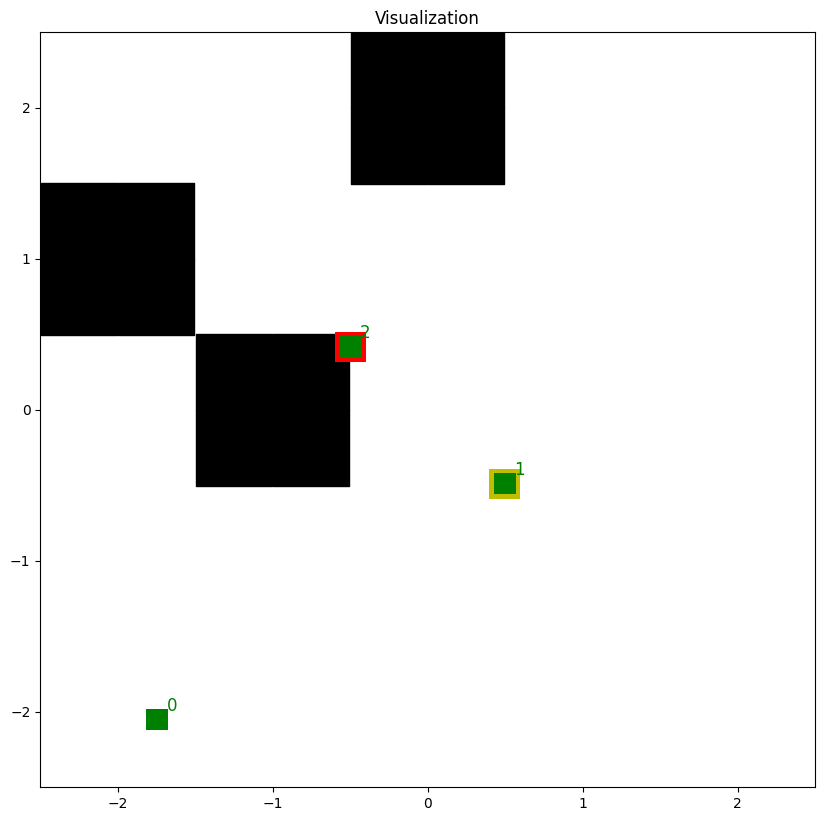

In [12]:
# Load the data
import os
PATH_DATA_FILE_PATH_TO_LOAD = os.path.join(CURRENT_DIR, 'dataset/data_path.json')
with open(PATH_DATA_FILE_PATH_TO_LOAD) as _file:
    RAW_DATA = json.load(_file)

idx = np.random.randint(len(RAW_DATA))
current_pos, goal_pos, occ_grid, path = RAW_DATA[idx]
visualize_data(occ_grid, current_pos, goal_pos, path)

# Proposed architectures

We propose and evaluate several feedforward architectures based on MLPs and CNNs to try and predict a reasonable next waypoint given a start and end goal. We also propose and evaluate several recurrent architectures to generate more temporally consistent paths. We implement these architectures and their dataloaders here.

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Definitions of feedforward networks and dataloaders

We implement a vanilla MLP that takes as input the vectorized occupancy grid concatenated in a single vector with the start and end goals. This MLP directly regresses the next waypoint position.

In [8]:
class MLPDataset(Dataset):
    """A dataset class for the MLP.
    
    Input: A vector that concat current position, goal position and occupancy grid vector
    Output: Next position
    """
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        start_pos, goal_pos, occ_grid, next_pos = self.dataset[idx]

        dim = len(start_pos)
        start_pos = torch.Tensor(start_pos)
        goal_pos = torch.Tensor(goal_pos)
        occ_grid = torch.Tensor(occ_grid)
        next_pos = torch.Tensor(next_pos)

        input = torch.cat((start_pos, goal_pos, occ_grid), dim=0).to(self.device)
        next_pos = next_pos.to(self.device)

        return input, next_pos
    
    def get_raw_data(self, idx):
        return self.dataset[idx]

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
            dataset = json.load(f)
        return cls(dataset, device=device)
    
    @classmethod
    def format_input_for_inference(cls, input):
        return input.view(1, -1)
    
    @classmethod
    def format_input_for_motion_planning(cls, input, current_pos):
        input[:2] = current_pos
        return input.view(1, -1)

In [9]:
class MLPModel(nn.Module):
    """A trivially simple MLP model."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.layers = nn.Sequential(
            nn.Linear(104, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, inputs):
        return self.layers(inputs)

As experiments detailed in the next section show, the MLP alone has difficulty with consistently estimating waypoints in non-obstacle regions. Since the MLP seems to not have fully learned the spatial cues needed to effectively distinguish obstacle/non-obstacle regions, we attempt to design an architecture comprising an MLP-based encoder (which learns to compress occupancy grid information as part of an autoencoder) followed by an MLP head which regresses the waypoints.

In [10]:
class MLPAutoencoderDataset(Dataset):
    """A dataset class for the MLP.
    
    Input: A vector that concat current position, goal position and occupancy grid vector
    Output: Next position
    """
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, _, occ_grid, _ = self.dataset[idx]
        occ_grid = torch.Tensor(occ_grid)
        occ_grid = occ_grid.to(self.device)
        return occ_grid
    
    def get_raw_data(self, idx):
        return self.dataset[idx]

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
            dataset = json.load(f)
        return cls(dataset, device=device)

In [11]:
class MLPEncoderModel(nn.Module):
    def __init__(self, feature_size):
        super(MLPEncoderModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, feature_size)
        )
    
    def forward(self, input):
        return self.layers(input)
    
class MLPDecoderModel(nn.Module):
    def __init__(self, feature_size):
        super(MLPDecoderModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(feature_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, 100)
        )
    
    def forward(self, input):
        return self.layers(input)
    
class MLPAutoencoderModel(nn.Module):
    def __init__(self):
        super(MLPAutoencoderModel, self).__init__()
        self.encoder = MLPEncoderModel(16)
        self.decoder = MLPDecoderModel(16)
        self.sig = nn.Sigmoid()
        
    def forward(self, input):
        features = self.encoder(input)
        output = self.decoder(features)
        return self.sig(output)

As a next step from the vanilla MLP, we implement a CNN-based model which we hypothesize could better capture the spatial information in the occupancy grid and estimate better waypoints.

In [12]:
class MLPCNNDataset(Dataset):
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        start_pos, goal_pos, occ_grid, next_pos = self.dataset[idx]

        dim = len(start_pos)
        start_pos = torch.Tensor(start_pos)
        goal_pos = torch.Tensor(goal_pos)
        occ_grid = torch.Tensor(occ_grid)
        next_pos = torch.Tensor(next_pos)

        positions = torch.cat((start_pos, goal_pos), dim=0).to(self.device)
        occ_grid = torch.unsqueeze(torch.reshape(occ_grid, (10, 10)), dim=0).to(self.device)
        next_pos = next_pos.to(self.device)

        return (occ_grid, positions), next_pos
    
    def get_raw_data(self, idx):
        return self.dataset[idx]

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
          dataset = json.load(f)
        return cls(dataset, device=device)
    
    @classmethod
    def format_input_for_inference(cls, input):
        occ_grid, pos = input
        return occ_grid.view(1, 1, 10, 10), pos.view(1, -1)
    
    @classmethod
    def format_input_for_motion_planning(cls, input, current_pos):
        occ_grid, pos = input
        pos[:2] = current_pos
        return occ_grid.view(1, 1, 10, 10), pos.view(1, -1)

In [13]:
class MLPCNNModel(nn.Module):
    def __init__(self):
        super(MLPCNNModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16*1, 4, stride=2, padding=1), # out = (16, 5, 5)
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # out = (32, 3, 3)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # out = (64, 2, 2)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # out = (128, 1, 1)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten()
            # nn.Conv2d(self.channel_mult*8, self.channel_mult*16, 3, 2, 1),
            # nn.BatchNorm2d(self.channel_mult*16),
            # nn.LeakyReLU(0.2, inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(128+4, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )

    def forward(self, inputs):
        img, positions = inputs
        # img_features = self.cnn(img).squeeze(dim=3).squeeze(dim=2)
        img_features = self.conv(img)
        features_positions = torch.cat((img_features, positions), dim=1)
        output = self.fc(features_positions)
        return output

In [16]:
class CNN_Encoder(nn.Module):
    def __init__(self, output_size, input_size=(1, 10, 10)):
        super(CNN_Encoder, self).__init__()

        self.input_size = input_size
        self.channel_mult = 16

        #convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1,
                     out_channels=self.channel_mult*1,
                     kernel_size=4,
                     stride=2,
                     padding=1), # out = (16, 5, 5)
            nn.LeakyReLU(),
            nn.Conv2d(self.channel_mult*1, self.channel_mult*2, 3, 2, 1), # out = (32, 3, 3)
            nn.BatchNorm2d(self.channel_mult*2),
            nn.LeakyReLU(),
            nn.Conv2d(self.channel_mult*2, self.channel_mult*4, 3, 2, 1), # out = (64, 2, 2)
            nn.BatchNorm2d(self.channel_mult*4),
            nn.LeakyReLU(),
            nn.Conv2d(self.channel_mult*4, self.channel_mult*8, 4, 2, 1), # out = (128, 1, 1)
            nn.BatchNorm2d(self.channel_mult*8),
            nn.LeakyReLU(),
            nn.Flatten()
            # nn.Conv2d(self.channel_mult*8, self.channel_mult*16, 3, 2, 1),
            # nn.BatchNorm2d(self.channel_mult*16),
            # nn.LeakyReLU(0.2, inplace=True)
        )

        # self.flat_fts = self.get_flat_fts(self.conv)
        self.flat_fts = 128

        self.linear = nn.Sequential(
            nn.Linear(self.flat_fts, output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(),
        )

    def get_flat_fts(self, fts):
        tmp = torch.ones(1, *self.input_size)
        f = fts(tmp)
        return int(np.prod(f.size()[1:]))

    def extract_feat(self, x):
        x = self.conv(x)
        x = x.view(-1, self.flat_fts)
        return x

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.flat_fts)
        return self.linear(x)

class CNN_Decoder(nn.Module):
    def __init__(self, embedding_size, input_size=(1, 10, 10)):
        super(CNN_Decoder, self).__init__()
        self.input_height = input_size[1]
        self.input_width = input_size[2]
        self.input_dim = embedding_size
        self.channel_mult = 16
        self.output_channels = 1
        self.fc_output_dim = 128 # 512

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.fc_output_dim),
            nn.BatchNorm1d(self.fc_output_dim),
            nn.LeakyReLU()
        )

        self.deconv = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(self.fc_output_dim, self.channel_mult*4, 4, 2, 1, bias=False), # out =(64, 2, 2)
            nn.BatchNorm2d(self.channel_mult*4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(self.channel_mult*4, self.channel_mult*2, 3, 2, 1, bias=False), # out =(32, 3, 3)
            nn.BatchNorm2d(self.channel_mult*2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(self.channel_mult*2, self.channel_mult*1, 3, 2, 1, bias=False), # out =(16, 5, 5)
            nn.BatchNorm2d(self.channel_mult*1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(self.channel_mult*1, self.output_channels, 4, 2, 1, bias=False), # out =(1, 10, 10)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.fc_output_dim, 1, 1)
        x = self.deconv(x)
        return x

class AE(nn.Module):
    def __init__(self, embedding_size=64):
        super(AE, self).__init__()
        self.encoder = CNN_Encoder(embedding_size)
        self.decoder = CNN_Decoder(embedding_size)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [17]:
class MLPCNNModel2(nn.Module):
    def __init__(self, pretrained_model_path=None):
        super(MLPCNNModel2, self).__init__()

        tmp_conv_encoder = CNN_Encoder(16)
        if pretrained_model_path:
            tmp_conv_encoder.load_state_dict(torch.load(os.path.join(CURRENT_DIR, pretrained_model_path)))

        self.conv_encoder = nn.Sequential(
            tmp_conv_encoder.conv,
            tmp_conv_encoder.linear[0]
        )

        self.fc = nn.Sequential(
            nn.Linear(16+4, 128),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)
        )

    def forward(self, inputs):
        img, positions = inputs
        img_features = self.conv_encoder(img).view(-1, 16)
        features_positions = torch.cat((img_features, positions), dim=1)
        output = self.fc(features_positions)
        return output

## Definitions of recurrent networks and dataloaders

In [18]:
class MLPRNNDataset(Dataset):
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        start_pos, goal_pos, occ_grid, path = self.dataset[idx]
        path_length = len(path) - 1
        
        start_seq = torch.Tensor(path[:-1]).to(self.device)
        goal_pos = torch.Tensor(path[-1]).to(self.device)
        input_seq = torch.cat((start_seq, goal_pos.repeat(path_length, 1)), dim=1)
        label_seq = torch.Tensor(path[1:]).to(self.device)
        occ_grid = torch.Tensor(occ_grid).to(self.device)

        return (input_seq, occ_grid), label_seq
    
    def get_raw_data(self, idx):
        return self.dataset[idx]

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
            dataset = json.load(f)
        return cls(dataset, device=device)
    
    @classmethod
    def format_input_for_inference(cls, input):
        input_seq, occ_grid = input
        return (
            torch.unsqueeze(input_seq, 0),
            occ_grid.view(1, -1)
        )
    
    @classmethod
    def format_input_for_motion_planning(cls, input, current_pos):
        input_seq, occ_grid = input
        goal = input_seq[0, 2:]
        concat = torch.cat((current_pos, goal))
        return concat.view(1, 1, -1), occ_grid.view(1, -1)

import random
import copy

class MLPRNNDataloader():
    def __init__(self, raw_data, batch_size, min_dataset_size=0, shuffle=True, 
                 drop_last=False, device="cpu", uniform_path_length=None):
        print("Raw data size: ", len(raw_data))
        self.shuffle = shuffle
            
        if uniform_path_length is not None:
            def truncate_fn(datum):
                _, goal, occ_grid, path = datum
                start = path[uniform_path_length - 1]
                return (start, goal, occ_grid, path[:uniform_path_length+1])
            
            filtered_data = filter(lambda datum: len(datum[3]) - 1 >= uniform_path_length, raw_data)
            truncated_data = list(map(truncate_fn, filtered_data))
            self.datasets = {uniform_path_length:MLPRNNDataset(truncated_data, device=device)}
            self.generators = {uniform_path_length:DataLoader(self.datasets[uniform_path_length], batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)}
            self.path_lengths = [uniform_path_length]
            print("All paths have length ", uniform_path_length)
            print("Reduced dataset size: ", len(truncated_data))
            return
        
        lengths = map(lambda datum: len(datum[3]) - 1, raw_data)
        partitions = {k:list() for k in lengths}
        for datum in raw_data:
            _, _, _, path = datum
            partitions[len(path) - 1].append(datum)

        remove = []
        for k, data_list in partitions.items():
            if len(data_list) < min_dataset_size:
                remove.append(k)
                print("Removing all paths of length ", k, ": only ", len(data_list), " samples")
            else:
                print("Adding all paths of length ", k, ": ", len(data_list), " samples")
        for k in remove:
            del partitions[k]

        self.datasets = {k:MLPRNNDataset(data_list, device=device) for k, data_list in partitions.items()}
        self.generators = {k:DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last) for k, dataset in self.datasets.items()}
        self.path_lengths = list(self.generators.keys())

    def __iter__(self):
        self.tmp_path_lengths = copy.deepcopy(self.path_lengths)
        if self.shuffle:
            random.shuffle(self.tmp_path_lengths)
        return self

    def __next__(self):
        if len(self.tmp_path_lengths) > 0:
            next_path_length = copy.deepcopy(self.tmp_path_lengths[-1])
            next_gen = self.generators[next_path_length]
            self.tmp_path_lengths.pop()
            return next_gen, next_path_length
        else:
            raise StopIteration
        
    @classmethod
    def load_dataset_from_file(cls, file_path, batch_size, train_frac, shuffle=True, drop_last=False, device="cpu", uniform_path_length=None):
      print("Loading data from {}".format(file_path))
      with open(file_path, 'r') as f:
          dataset = json.load(f)

      train_size = int(train_frac * len(dataset))
      if train_size < len(dataset):
          train_dataset = dataset[:train_size]
          val_dataset = MLPRNNDataset(dataset[train_size:], device=device)
      else:
          train_dataset = dataset
          val_dataset = MLPRNNDataset([], device=device)

      return (
          cls(train_dataset, batch_size, shuffle=shuffle, drop_last=drop_last, device=device, uniform_path_length=uniform_path_length), 
          DataLoader(val_dataset, batch_size=1, shuffle=False)
      )

In [19]:
class MLPRNNModel(nn.Module):
    def __init__(self, latent_size):
        super(MLPRNNModel, self).__init__()

        self.map_embedding = nn.Sequential(
            nn.Linear(100, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, latent_size)
        )

        self.goal_embedding =  nn.Sequential(
            nn.Linear(4, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
        )

        self.rnn = nn.RNN(latent_size, latent_size, batch_first=True)

        self.mlp_regression = nn.Sequential(
            nn.Linear(latent_size, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
        self.latent_size = latent_size

    def forward(self, inputs, h_init, initialise=False):
        input_seq, occ_grid = inputs
        batch_size, seq_length, num_dims = input_seq.shape

        # h_init not explicitly used in this implementation; instead we overwrite h_init with the map embedding
        if initialise:
            h = torch.unsqueeze(self.map_embedding(occ_grid), 0) + h_init
        else:
            h = h_init

        # RNN
        g_seq = self.goal_embedding(input_seq)
        h_seq, h_final = self.rnn(g_seq, h)
        regressed_seq = self.mlp_regression(h_seq)

        return regressed_seq, h_final
    
    def init_with_zeros(self, batch_size):
        return torch.zeros(1, batch_size, self.latent_size).to(DEVICE)

# Training

We implement the training pass, and train and evaluate the architectures proposed in the previous section.

## Implementing utilities

Before implementing the training passes, we develop some utilities needed during training, to help visualise and evaluate the progress of training, and performance of the trained models.

This is a utility to visualise the losses on the training and validation sets during training.

In [15]:
import time
from matplotlib.lines import Line2D

def init_training_loss_visualiser(num_epochs):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim(0, num_epochs + 1)
    ax.set_ylim(0, 2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and validation loss')
    
    legend_lines = [Line2D([0], [0], color='b', lw=3),
                    Line2D([0], [0], color='r', lw=3)]
    ax.legend(legend_lines, ['Training loss', 'Validation loss'])
    return fig, ax

def visualise_loss(fig, ax, training_losses, val_losses):
    epochs = list(range(len(training_losses)))
    ax.plot(epochs, training_losses, 'b')
    ax.plot(epochs, val_losses, 'r')
    fig.canvas.draw()
    time.sleep(0.1)

This evaluates the average loss of the model on the test dataset

In [16]:
def evaluate_test_metrics(test_dataloader, model, criterion, is_recurrent=False):
    i = 0
    total_loss = 0
    test_dataloader = [test_dataloader] if not is_recurrent else test_dataloader
    
    model.eval()
    with torch.no_grad():
        for entry in test_dataloader:
            if is_recurrent:
                dataloader, path_length = entry
                print(f"Evaluating data with path length: {path_length}")
            else:
                dataloader = entry
            
            for data in dataloader:
                # Get batch of data
                inputs, labels = data

                # Check if an RNN is being evaluated, and initialise hidden state if so
                if is_recurrent:
                    batch_size = inputs[0].shape[0]
                    h_init = model.init_with_zeros(batch_size)
                    network_output, _ = model.forward(inputs, h_init, initialise=True)
                else:
                    network_output = model.forward(inputs)

                # Compute loss
                loss = criterion(network_output, labels)
                # Print statistics
                total_loss += loss.detach().item()
                i += 1
        print(f'Average loss :{total_loss / i}')

This allows us to visualize the waypoints/paths generated by the model and compare it to ground truth waypoints/paths

In [17]:
def visualize_model_output(dataset, model, is_recurrent=False):
    idx = np.random.randint(len(dataset))
    inputs, _ = dataset[idx]
    current_pos, goal_pos, occ_grid, gt = dataset.get_raw_data(idx)
    
    model.eval()
    with torch.no_grad():
        if is_recurrent:
            h_init = model.init_with_zeros(1)
            predicted, _ = model.forward(dataset.format_input_for_inference(inputs), h_init, initialise=True)
            predicted_path = torch.squeeze(predicted.detach()).cpu().numpy()
            visualize_data(occ_grid, gt[0], gt[-1], gt[1:], predicted_path=predicted_path)
        else:
            predicted = model.forward(dataset.format_input_for_inference(inputs))
            visualize_data(occ_grid, current_pos, goal_pos, [gt], predicted_path=[predicted.detach().cpu().numpy().flatten()])

## Implementing training pass

Implement the training procedures for both feedforward as well as recurrent network architectures.

We implement a training loop for feedforward architectures designed to regress the waypoints given the occupancy grid, start and end goals.

In [25]:
def train_feedforward(
        model,
        train_dataloader,
        eval_dataloader,
        criterion=None,
        batch_size=64,
        learning_rate=1e-4,
        num_epochs=10,
        model_string="checkpoint"
        ):
    if criterion is None:
        print(f"Using MSE loss as default loss function")
        criterion = torch.nn.MSELoss()
    
    model_save_path = os.path.join(CURRENT_DIR, f'models/{model_string}.pt')
    print(f"Checkpoint save path: {model_save_path}")

    fig, ax = init_training_loss_visualiser(num_epochs)
    train_losses = []
    val_losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    torch.autograd.set_detect_anomaly(True)

    # Run the training loop
    i = 0
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch} starts")
        total_loss = 0
        print("--------Training")
        for data in train_dataloader:
            # Get batch of data
            inputs, labels = data
            # Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            #print(inputs.shape, labels.shape)
            network_output = model.forward(inputs)
            #print(network_output.shape)
            # Compute loss
            loss = criterion(network_output, labels)
            # Ensure no funny numerics
            assert not torch.isnan(loss).any()
            # Perform backward pass
            loss.backward()
            # 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            # Perform optimization
            optimizer.step()
            # Print statistics
            total_loss += loss.detach().item()
            i += 1
            if i % 100 == 0:
                # average_loss = total_loss / i
                average_loss = loss.item()
                rms = np.sqrt(average_loss)
                print('-----------------Average loss/RMS error after mini-batch %5d, epoch %d : %.3f, %.3f' % (i, epoch, average_loss, rms))
        train_losses.append(total_loss / i)

        # Evaluate on validation set at end of each epoch
        model.eval()
        total_loss = 0

        for data in eval_dataloader:
            # Get batch of data
            inputs, labels = data
            # Perform forward pass
            network_output = model.forward(inputs)
            # Compute loss
            loss = criterion(network_output, labels)
            total_loss += loss.detach().item()

        average_loss = total_loss / len(eval_dataloader)
        rms = np.sqrt(average_loss)
        print("--------Evaluation")
        print('-----------------Total loss/RMS error after epoch %5d: %.3f, %.3f' % (epoch, average_loss, rms))
        
        val_losses.append(average_loss)
        visualise_loss(fig, ax, train_losses, val_losses)
            
    torch.save(model.state_dict(), model_save_path)
    
    print(f"-----------------saved epoch {epoch} to ", model_save_path)

We implement a training loop to train autoencoder architectures to reproduce the occupancy grid. Through this we hope to create encoders that have effectively captured the spatial information of the occupancy grids, and which we can use to create latent representations of the occupancy grids in our other models.

In [26]:
import torch.nn.functional as F

def train_autoencoder(
        model,
        train_dataloader,
        eval_dataloader,
        criterion=None,
        batch_size=64,
        learning_rate=1e-4,
        num_epochs=10,
        model_string="checkpoint"
        ):
    if criterion is None:
        print(f"Using MSE loss as default loss function")
        criterion = torch.nn.MSELoss()
    
    model_save_path = os.path.join(CURRENT_DIR, f'models/{model_string}.pt')
    print(f"Checkpoint save path: {model_save_path}")

    fig, ax = init_training_loss_visualiser(num_epochs)
    train_losses = []
    val_losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    torch.autograd.set_detect_anomaly(True)

    # Run the training loop
    i = 0
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch} starts")
        total_loss = 0
        print("--------Training")
        for data in train_dataloader:
            # Get batch of data
            occ_grids = data
            # Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            soft_network_output = model.forward(occ_grids)
            # Compute loss
            soft_occ_grids = F.sigmoid(occ_grids)
            loss = criterion(soft_network_output, soft_occ_grids)
            # Ensure no funny numerics
            assert not torch.isnan(loss).any()
            # Perform backward pass
            loss.backward()
            # 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            # Perform optimization
            optimizer.step()
            # Print statistics
            total_loss += loss.detach().item()
            i += 1
            if i % 100 == 0:
                average_loss = total_loss / i
                rms = np.sqrt(average_loss)
                print('-----------------Average loss/RMS error after mini-batch %5d, epoch %d : %.3f, %.3f' % (i, epoch, average_loss, rms))
        train_losses.append(total_loss / i)

        # Evaluate on validation set at end of each epoch
        model.eval()
        total_loss = 0

        for data in eval_dataloader:
            # Get batch of data
            occ_grids = data
            # Perform forward pass
            soft_occ_grids = F.sigmoid(occ_grids)
            soft_network_output = model.forward(occ_grids)
            # Compute loss
            loss = criterion(soft_network_output, soft_occ_grids)
            total_loss += loss.detach().item()

        average_loss = total_loss / len(eval_dataloader)
        rms = np.sqrt(average_loss)
        print("--------Evaluation")
        print('-----------------Total loss/RMS error after epoch %5d: %.3f, %.3f' % (epoch, average_loss, rms))
        
        val_losses.append(average_loss)
        visualise_loss(fig, ax, train_losses, val_losses)
            
    torch.save(model.state_dict(), model_save_path)
    
    print(f"-----------------saved epoch {epoch} to ", model_save_path)

We implement a training loop to train recurrent architectures that can retain memory of past waypoints while regressing future waypoints.

In [27]:
def normalize_gradient(net):
    grad_norm_sq=0
    for p in net.parameters():
        grad_norm_sq += p.grad.data.norm()**2

    grad_norm=math.sqrt(grad_norm_sq)
    if grad_norm<1e-4:
        net.zero_grad()
        print('grad norm close to zero')
    else:    
        for p in net.parameters():
             p.grad.data.div_(grad_norm)

    return grad_norm

def train_recurrent(
        model,
        network_hidden_size,
        train_dataloaders,
        eval_dataloader,
        criterion=None,
        batch_size=64,
        learning_rate=1e-4,
        num_epochs=10,
        model_string="checkpoint"
        ):
    if criterion is None:
        print(f"Using MSE loss as default loss function")
        criterion = torch.nn.MSELoss()
        
    fig, ax = init_training_loss_visualiser(num_epochs)
    train_losses = []
    val_losses = []
        
    model_save_path = os.path.join(CURRENT_DIR, f'models/{model_string}.pt')
    print(f"Checkpoint save path: {model_save_path}")
        
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    torch.autograd.set_detect_anomaly(True)

    # Run the training loop
    i = 0
    frac = 0.0
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch} starts")
        total_loss = 0
        print("--------Training")

        for dataloader, path_length in train_dataloaders:
            print("Training on dataset with path length: ", path_length)
            for data in dataloader:
                # Get batch of data
                inputs, labels = data
                # Zero the gradients
                optimizer.zero_grad()
                # Initialise the hidden state
                h_init = torch.zeros(1, inputs[0].shape[0], network_hidden_size).to(DEVICE)
                # Perform forward pass
                output, _ = model.forward(inputs, h_init, initialise=True)
                # Compute loss
                loss = criterion(output, labels)
                # Ensure no funny numerics
                assert not torch.isnan(loss).any()
                # Perform backward pass
                loss.backward()
                # Clip gradients to prevent explosion
                normalize_gradient(model)
                # Perform optimization
                optimizer.step()

                # Print statistics
                total_loss += loss.detach().item()
                i += 1
                frac += float(inputs[0].shape[0]) / float(batch_size)
                if i % 100 == 0:
                    #average_loss = total_loss / frac
                    average_loss = total_loss / i
                    rms = np.sqrt(average_loss)
                    print('-----------------Average loss/RMS error after mini-batch %5d, epoch %d : %.3f, %.3f' % (i, epoch, average_loss, rms))
                    
        train_losses.append(total_loss / i)
        
        # Evaluate on validation set at end of each epoch
        model.eval()
        total_loss = 0

        for data in eval_dataloader:
            # Get batch of data
            inputs, labels = data
            # Perform forward pass
            h_init = torch.zeros(1, inputs[0].shape[0], network_hidden_size).to(DEVICE)
            network_output, _ = model.forward(inputs, h_init, initialise=True)
            # Compute loss
            loss = criterion(network_output, labels)
            total_loss += loss.detach().item()

        average_loss = total_loss / len(eval_dataloader)
        rms = np.sqrt(average_loss)
        print("--------Evaluation")
        print('-----------------Total loss/RMS error after epoch %5d: %.3f, %.3f' % (epoch, average_loss, rms))
        
        val_losses.append(average_loss)
        visualise_loss(fig, ax, train_losses, val_losses)
                    
        # save at each epoch
        torch.save({
            'model_state_dict': model.state_dict(),
            'rnn_hidden_size': model.latent_size
        }, model_save_path)

## Training feedforward architectures

Implement some utilities for loading data

In [28]:
def init_feedforward_dataloaders(dataset_cls, train_frac, batch_size):
    train_val_dataset = dataset_cls.load_dataset_from_file(os.path.join(CURRENT_DIR, 'dataset/data_waypoints.json'), device=DEVICE)
    train_size = int(len(train_val_dataset) * train_frac)
    
    train_set, val_set = torch.utils.data.random_split(train_val_dataset, [train_size, len(train_val_dataset) - train_size])
    #train_set = torch.utils.data.Subset(train_val_dataset, np.arange(train_size))
    #val_set = torch.utils.data.Subset(train_val_dataset, np.arange(train_size, len(train_val_dataset)))
    test_set = dataset_cls.load_dataset_from_file(os.path.join(CURRENT_DIR, 'test_dataset/data_waypoints.json'), device=DEVICE)
    
    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    eval_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, eval_dataloader, test_dataloader, test_set

Train a vanilla MLP to predict next waypoint

In [ ]:
# Parameters specific to this instantiation of the model and its training
model_string = "MLP_test3"
train_frac = 0.9 # Proportion of dataset to use as train set (otherwise will be validation)
batch_size = 64
learning_rate = 1e-4
num_epochs = 10
criterion = torch.nn.MSELoss()
model_cls = MLPModel
train_loader, eval_loader, test_loader, test_raw = init_feedforward_dataloaders(MLPDataset, train_frac, batch_size)

# Train
model = model_cls().to(DEVICE)
train_feedforward(model, train_loader, eval_loader, criterion=criterion, batch_size=batch_size, 
                  learning_rate=learning_rate, num_epochs=num_epochs, model_string=model_string)

# Evaluate
evaluate_test_metrics(test_loader, model, criterion)

In [ ]:
# Visualize random prediction on test set
visualize_model_output(test_raw, model)

Train a vanilla CNN with a fully-connected head to predict next waypoint

Loading data from ./dataset/data_waypoints.json
dataset size = 320702
Loading data from ./test_dataset/data_waypoints.json
dataset size = 1240
Checkpoint save path: ./models/MLPCNN_test2.pt
Epoch 0 starts
--------Training
-----------------Average loss/RMS error after mini-batch   100, epoch 0 : 0.436, 0.660
-----------------Average loss/RMS error after mini-batch   200, epoch 0 : 0.401, 0.634
-----------------Average loss/RMS error after mini-batch   300, epoch 0 : 0.400, 0.633
-----------------Average loss/RMS error after mini-batch   400, epoch 0 : 0.329, 0.573
-----------------Average loss/RMS error after mini-batch   500, epoch 0 : 0.339, 0.582
-----------------Average loss/RMS error after mini-batch   600, epoch 0 : 0.284, 0.533
-----------------Average loss/RMS error after mini-batch   700, epoch 0 : 0.255, 0.505
-----------------Average loss/RMS error after mini-batch   800, epoch 0 : 0.332, 0.576
-----------------Average loss/RMS error after mini-batch   900, epoch 0 : 0.268, 0

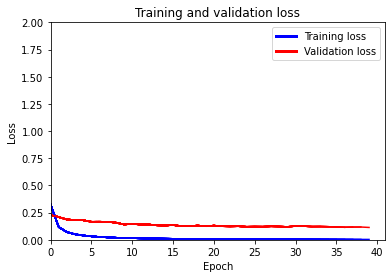

In [69]:
# Parameters specific to this instantiation of the model and its training
model_string = "MLPCNN_test2"
train_frac = 0.9 # Proportion of dataset to use as train set (otherwise will be validation)
batch_size = 128
learning_rate = 1e-4
num_epochs = 40
criterion = torch.nn.MSELoss()
model_cls = MLPCNNModel
train_loader, eval_loader, test_loader, test_raw = init_feedforward_dataloaders(MLPCNNDataset, train_frac, batch_size)

# Train
model = model_cls().to(DEVICE)
train_feedforward(model, train_loader, eval_loader, criterion=criterion, batch_size=batch_size, 
                  learning_rate=learning_rate, num_epochs=num_epochs, model_string=model_string)

# model.load_state_dict(torch.load(os.path.join(CURRENT_DIR, "models/MLPCNN_test.pt")))

# Evaluate
evaluate_test_metrics(test_loader, model, criterion)

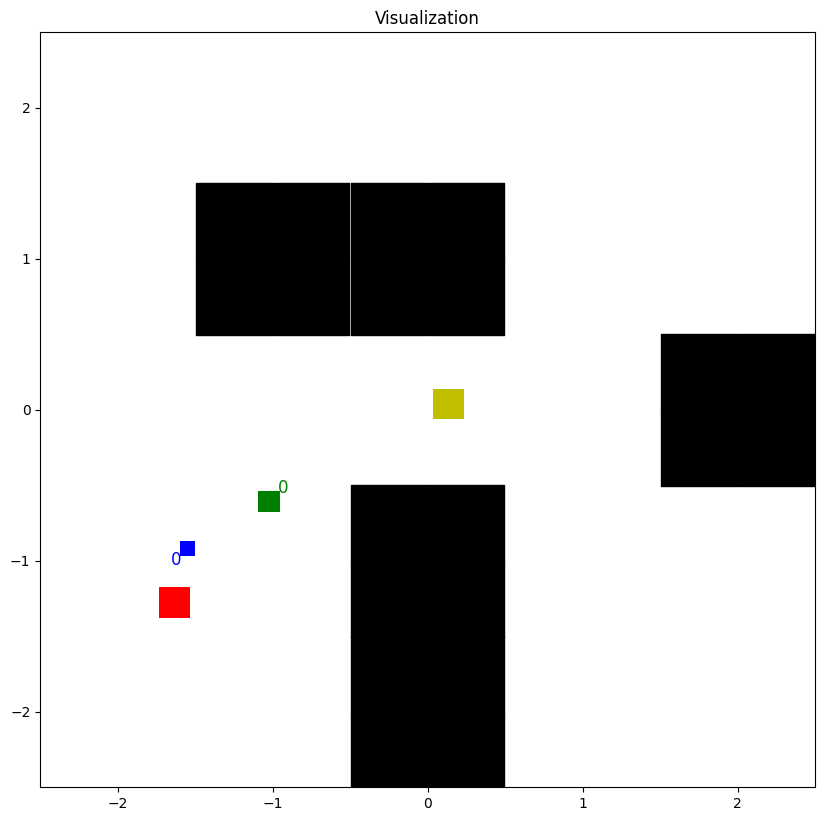

In [75]:
# Visualize random prediction on test set
visualize_model_output(test_raw, model)

Train an MLP autoencoder to reconstruct the occupancy grid, with the aim of extracting the encoder and using it to generate a latent representation of the grid in other models.

In [ ]:
# Parameters specific to this instantiation of the model and its training
model_string = "MLPAutoencoder"
train_frac = 0.9 # Proportion of dataset to use as train set (otherwise will be validation)
batch_size = 64
learning_rate = 1e-2
num_epochs = 10
criterion = torch.nn.BCELoss()
model_cls = MLPAutoencoderModel
train_loader, eval_loader, test_loader, test_raw = init_feedforward_dataloaders(MLPAutoencoderDataset, train_frac, batch_size)

# Train
model = model_cls().to(DEVICE)
train_autoencoder(model, train_loader, eval_loader, criterion=criterion, batch_size=batch_size, 
                  learning_rate=learning_rate, num_epochs=num_epochs, model_string=model_string)

Test a MLP-CNN architecture, where the convolutional encoder (CNN) has first been trained as part of an autoencoder to learn a compressed representation of the map. The encoder is pretrained on a different dataset of occupancy grids, and is finetuned here.

In [ ]:
# Parameters specific to this instantiation of the model and its training
model_string = "MLPPretrainedConvEncoder_test2"
train_frac = 0.9 # Proportion of dataset to use as train set (otherwise will be validation)
batch_size = 64
learning_rate = 1e-4
num_epochs = 20
criterion = torch.nn.MSELoss()
model_cls = MLPCNNModel2
train_loader, eval_loader, test_loader, test_raw = init_feedforward_dataloaders(MLPCNNDataset, train_frac, batch_size)

# Train
model = model_cls(pretrained_model_path="models/conv_encoder_7.pt").to(DEVICE)
train_feedforward(model, train_loader, eval_loader, criterion=criterion, batch_size=batch_size, 
                  learning_rate=learning_rate, num_epochs=num_epochs, model_string=model_string)

# Evaluate
evaluate_test_metrics(test_loader, model, criterion)

In [ ]:
# Visualize random prediction on test set
visualize_model_output(test_raw, model)

## Training recurrent architectures

Implement utilities for loading data

In [61]:
def init_recurrent_dataloaders(cls, train_frac, batch_size):
    train_loaders, data_loader = MLPRNNDataloader.load_dataset_from_file(
        os.path.join(CURRENT_DIR, 'dataset/data_path.json'), batch_size, train_frac,
        shuffle=True, drop_last=True, device=DEVICE
    )
    
    TEST_DATA_PATH = os.path.join(CURRENT_DIR, 'test_dataset/data_path.json')
    test_loader, _ = MLPRNNDataloader.load_dataset_from_file(TEST_DATA_PATH, batch_size, 1.0, 
                                                             shuffle=False, drop_last=False, device=DEVICE)
    test_set = cls.load_dataset_from_file(TEST_DATA_PATH, device=DEVICE)
    
    return train_loaders, data_loader, test_loader, test_set

Implement a basic RNN to predict the path from start to goal. At each timestep, the input to the RNN is the concatenation of its current position and the goal position, and the output is the next waypoint it should head towards. The RNN is conditioned on the obstacle grid - this is done by encoding the obstacle grid in a feature vector using an MLP, and adding the feature vector to the RNN's initial hidden state.

Loading data from .\dataset/data_path.json
dataset size = 4252
Raw data size:  38268
Adding all paths of length  2 :  13900  samples
Adding all paths of length  3 :  13322  samples
Adding all paths of length  4 :  6623  samples
Adding all paths of length  5 :  2697  samples
Adding all paths of length  6 :  1005  samples
Adding all paths of length  7 :  382  samples
Adding all paths of length  9 :  104  samples
Adding all paths of length  8 :  190  samples
Adding all paths of length  10 :  22  samples
Adding all paths of length  11 :  23  samples
dataset size = 13900
dataset size = 13322
dataset size = 6623
dataset size = 2697
dataset size = 1005
dataset size = 382
dataset size = 104
dataset size = 190
dataset size = 22
dataset size = 23
Loading data from .\test_dataset/data_path.json
dataset size = 0
Raw data size:  377
Adding all paths of length  3 :  173  samples
Adding all paths of length  2 :  71  samples
Adding all paths of length  5 :  37  samples
Adding all paths of length  6 : 

<IPython.core.display.Javascript object>


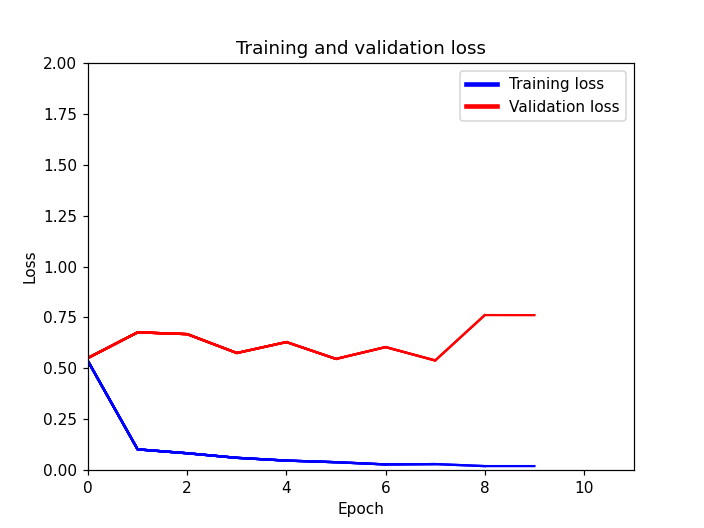

Checkpoint save path: .\models/MLPRNN_test6.pt
Epoch 0 starts
--------Training
Training on dataset with path length:  8
Training on dataset with path length:  5
Training on dataset with path length:  2
-----------------Average loss/RMS error after mini-batch   100, epoch 0 : 1.329, 1.153
-----------------Average loss/RMS error after mini-batch   200, epoch 0 : 1.004, 1.002
Training on dataset with path length:  6
Training on dataset with path length:  7
Training on dataset with path length:  10
Training on dataset with path length:  11
Training on dataset with path length:  9
Training on dataset with path length:  4
-----------------Average loss/RMS error after mini-batch   300, epoch 0 : 0.833, 0.913
Training on dataset with path length:  3
-----------------Average loss/RMS error after mini-batch   400, epoch 0 : 0.704, 0.839
-----------------Average loss/RMS error after mini-batch   500, epoch 0 : 0.606, 0.778
--------Evaluation
-----------------Total loss/RMS error after epoch     0

Training on dataset with path length:  11
--------Evaluation
-----------------Total loss/RMS error after epoch     7: 0.538, 0.734
Epoch 8 starts
--------Training
Training on dataset with path length:  8
Training on dataset with path length:  2
-----------------Average loss/RMS error after mini-batch  4800, epoch 8 : 0.003, 0.054
-----------------Average loss/RMS error after mini-batch  4900, epoch 8 : 0.004, 0.067
Training on dataset with path length:  7
Training on dataset with path length:  11
Training on dataset with path length:  4
-----------------Average loss/RMS error after mini-batch  5000, epoch 8 : 0.010, 0.099
Training on dataset with path length:  3
-----------------Average loss/RMS error after mini-batch  5100, epoch 8 : 0.013, 0.113
-----------------Average loss/RMS error after mini-batch  5200, epoch 8 : 0.014, 0.120
Training on dataset with path length:  5
-----------------Average loss/RMS error after mini-batch  5300, epoch 8 : 0.017, 0.131
Training on dataset with pa

In [261]:
# Parameters specific to this instantiation of the model and its training
model_string = "MLPRNN_test7"
train_frac = 0.9 # Proportion of dataset to use as train set (otherwise will be validation)
batch_size = 64
learning_rate = 1e-4
num_epochs = 10
criterion = torch.nn.MSELoss()
model_cls = MLPRNNModel
network_hidden_size = 128
train_loaders, eval_loader, test_loader, test_raw = init_recurrent_dataloaders(MLPRNNDataset, train_frac, batch_size)

# Train
model = model_cls(network_hidden_size).to(DEVICE)
train_recurrent(model, network_hidden_size, train_loaders, eval_loader, criterion=criterion, batch_size=batch_size, 
                learning_rate=learning_rate, num_epochs=num_epochs, model_string=model_string)

# Evaluate
evaluate_test_metrics(test_loader, model, criterion, is_recurrent=True)

<IPython.core.display.Javascript object>


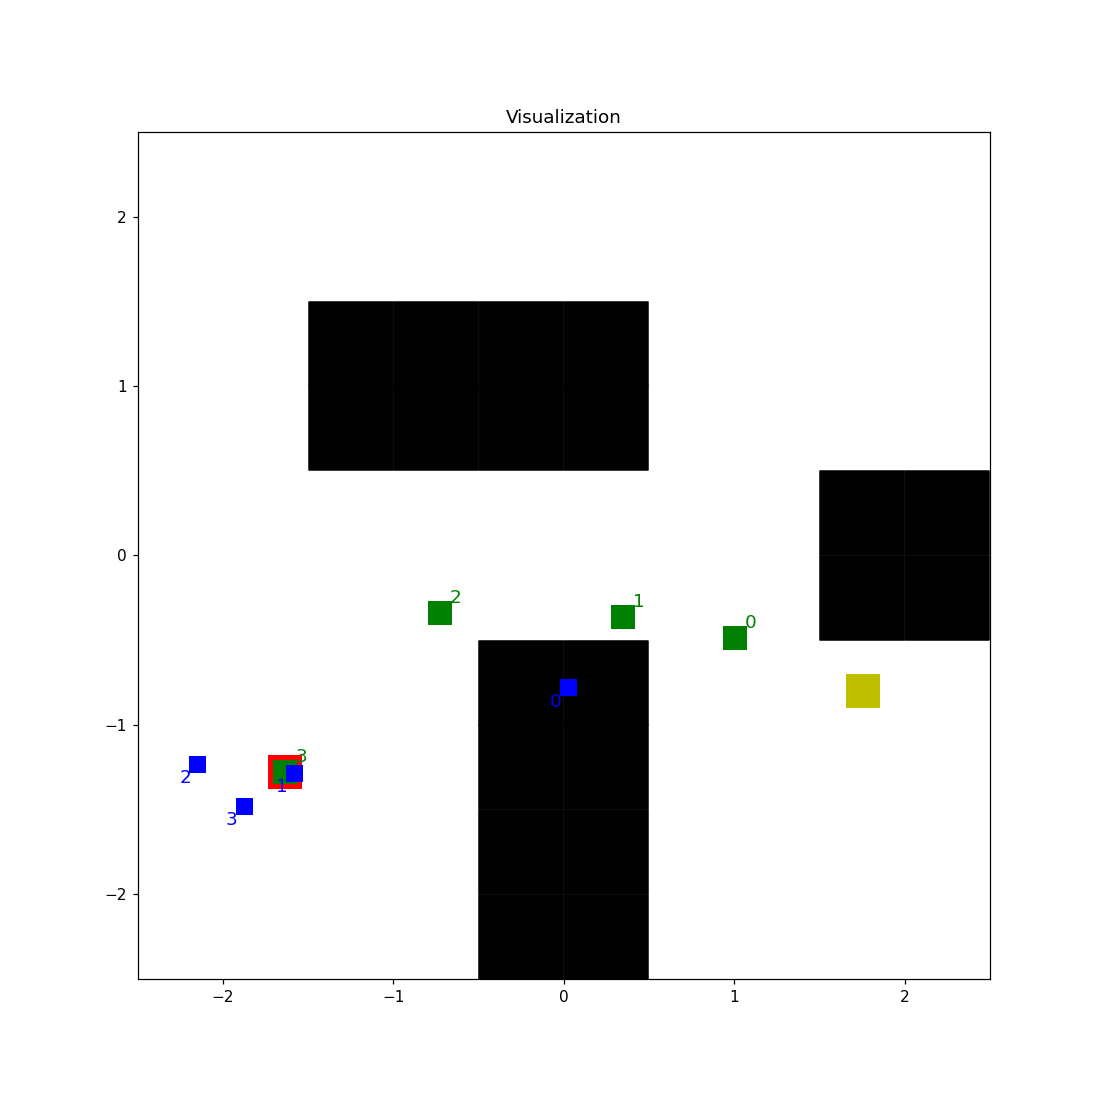

In [157]:
# Visualize random prediction on test set
visualize_model_output(test_raw, model, is_recurrent=True)

# Evaluation

We present here the consolidated results from training and evaluating the proposed network architectures. We also focus on running evaluating the performance of our models on a full motion planning test set-up. Our previous evaluation focused on predicting waypoints one step ahead. In contrast we will now run the inference iteratively to continuously generate waypoints based on the last generated waypoint, and attempt to generate a full path linking the start to the end goal.

## Evaluation of proposed network architectures

We will evaluate the performance of the trained network architectures using the following criteria:
* Validation and test loss. Since we train with a mean-squared error loss between the regressed waypoints and ground truth waypoints, the square root of the validation loss indicates how far on average the regressed waypoints are from ground truth.
* Success rate in generating a next waypoint that is directly reachable from current position and not obstructed by obstacles.

## Motion planning test

We created a test dataset of 100 environments. In each environment we have sampled start and goal positions, and computed a feasible path between them using A* search.

We will evaluate the performance of the motion planning test based on two criteria:
* Success rate at generating a feasible path to goal. Success is defined as a generated waypoint reaching the goal within a given tolerance of 0.2m within 15 steps, while not colliding with obstacles along the way.
* Length of predicted path compared to ground truth path length. This is given by the path length ratio $$\frac{l_i}{\max(p_i, l_i)}$$. $l_i$ is the shortest path length and $p_i$ is the predicted path length. The shortest path length will be approximated using the length of the ground truth path computed. 

Both of these metrics can also be unified into a single metric termed the success weighted by (normalized inverse) path length (SPL) [1]. Specifically, the SPL is
$$ \frac{1}{N} \sum\limits_{i=1}^{N} S_i \frac{l_i}{\max(p_i, l_i)} $$, where $N$ is the number of motion planning test episodes and $S_i$ is an indicator variable which is 1 if the test succeeds.

First, we implement the utilities for running motion planning.

In [38]:
import copy
import random
import numpy as np

def single_motion_planning_test(model, dataset, idx, max_iters=5, is_recurrent=False, check_collision=False):
    status = 'SUCCESS'
    inputs, _ = dataset[idx]
    _, goal_pos, occ_grid, gt = dataset.get_raw_data(idx)
    maze = Maze2D.load_small_occupancy_grid(occ_grid)
    
    current_pos = np.array(gt[0], dtype=np.float32)
    goal_pos = np.array(goal_pos)
    it = 0
    predicted_path = [gt[0]]
    planned_path = [gt[0]]
    hidden_state = None if not is_recurrent else model.init_with_zeros(1)
    
    model.eval()
    with torch.no_grad():
        total_col_length = 0
        total_path_length = 0
        while np.linalg.norm(current_pos - goal_pos) > 0.5:
            if it >= max_iters:
                status = 'NOT-REACH'
                break

            formatted = dataset.format_input_for_motion_planning(inputs, torch.from_numpy(current_pos).to(DEVICE))
            if is_recurrent:
                output, hidden_state = model.forward(formatted, hidden_state, initialise=(it==0))
                predicted = torch.squeeze(output.detach()).cpu().numpy().flatten()
            else:
                output = model.forward(formatted)
                predicted = output.detach().cpu().numpy().flatten()
            
            predicted_path.append(predicted.tolist())
            current_pos = predicted
            
            if check_collision:
                # if ( (len(predicted_path) == 1 and not maze.is_state_valid(predicted)) or
                #      (len(predicted_path) > 1 and not utils.is_edge_free(maze, predicted_path[-2], predicted_path[-1])) ):
                #     status = 'COLLIDED'
                #     print('COLLIDED at it {}'.format(it))
                #     break
                # current_pos = utils.extend(maze, planned_path[-1], predicted_path[-1])
                # planned_path.append(current_pos)
                col_length = utils.get_edge_collision_length(maze, predicted_path[-2], predicted_path[-1])
                total_col_length += col_length
                edge_length = utils.cal_edge_length(predicted_path[-2], predicted_path[-1])
                total_path_length += edge_length

            it += 1
        if check_collision:
            col_prop = total_col_length / total_path_length
        else:
            col_prop = 0
        return status, np.array(predicted_path), occ_grid, gt, col_prop
    
def test_over_data(model, data, dataset_cls, number=100, is_recurrent=False, check_collision=False):
    success_count = 0.0
    data = copy.deepcopy(data)
    random.shuffle(data)
    count = 0
    test_set = dataset_cls(data, device=DEVICE)
    path_length_ratio = 0.0
    number = len(data) if number < 0 else number
    
    for idx in range(number):
        if count % 10 == 0:
          print("Tested ", count)
        count += 1
        status, predicted_path, _, gt_path, col_prop = single_motion_planning_test(
            model, test_set, idx, is_recurrent=is_recurrent, check_collision=check_collision)
        if status == 'SUCCESS':
            success_count += (1 - col_prop)
            predicted_path = np.array(predicted_path)
            gt_path = np.array(gt_path)
            predicted_path_length = np.sum(np.linalg.norm(predicted_path[1:,:] - predicted_path[:-1,:], axis=1))
            gt_path_length = np.sum(np.linalg.norm(gt_path[1:,:] - gt_path[:-1,:], axis=1))
            path_length_ratio += gt_path_length / max(predicted_path_length, gt_path_length)
    return success_count / number, (0 if success_count == 0 else path_length_ratio / success_count)

def load_feedforward_model(model_cls, model_string):
    model = model_cls()
    model_dir = os.path.join(CURRENT_DIR, 'models')
    model.load_state_dict(torch.load(os.path.join(model_dir, model_string + ".pt")))
    model.to(DEVICE)
    return model

def load_recurrent_model(model_cls, model_string):
    model_dir = os.path.join(CURRENT_DIR, 'models')
    model_dict = torch.load(os.path.join(model_dir, model_string + ".pt"))
    model_hidden_size = model_dict['rnn_hidden_size']
    model = model_cls(model_hidden_size)
    model.load_state_dict(model_dict['model_state_dict'])
    model.to(DEVICE)
    return model

### Visualising individual motion planning tests

We visualise the planned paths iteratively generated by our proposed network architectures on randomly selected test cases from our test dataset.

1. We test a simple CNN-based model consisting of a convolutional encoder with a fully-connected head for regressing the next waypoint. The convolutional encoder is extracted from an autoencoder trained to reconstruct the obstacle grid, and is finetuned with the fully-connected head on our waypoint dataset.

In [16]:
### Motion planning test with CNN based model ###
# Load data once, so we do not have to load repeatedly
test_set = MLPCNNDataset.load_dataset_from_file(os.path.join(CURRENT_DIR, 'test_dataset/data_path.json'), device=DEVICE)

Loading data from ./test_dataset/data_path.json
dataset size = 377


In [19]:
# Select a random test case, perform motion planning with iterative inferences and visualise results
model = load_feedforward_model(MLPCNNModel2, "MLPPretrainedConvEncoder")
idx = np.random.randint(len(test_set))
status, predicted_path, occ_grid, gt_path = single_motion_planning_test(
    model, test_set, idx, check_collision=False)
print(f'Status: {status}')
visualize_data(occ_grid, gt_path[0], gt_path[-1], gt_path[1:], predicted_path)

NameError: name 'MLPCNNModel2' is not defined

Status: SUCCESS
0.12485719000584995


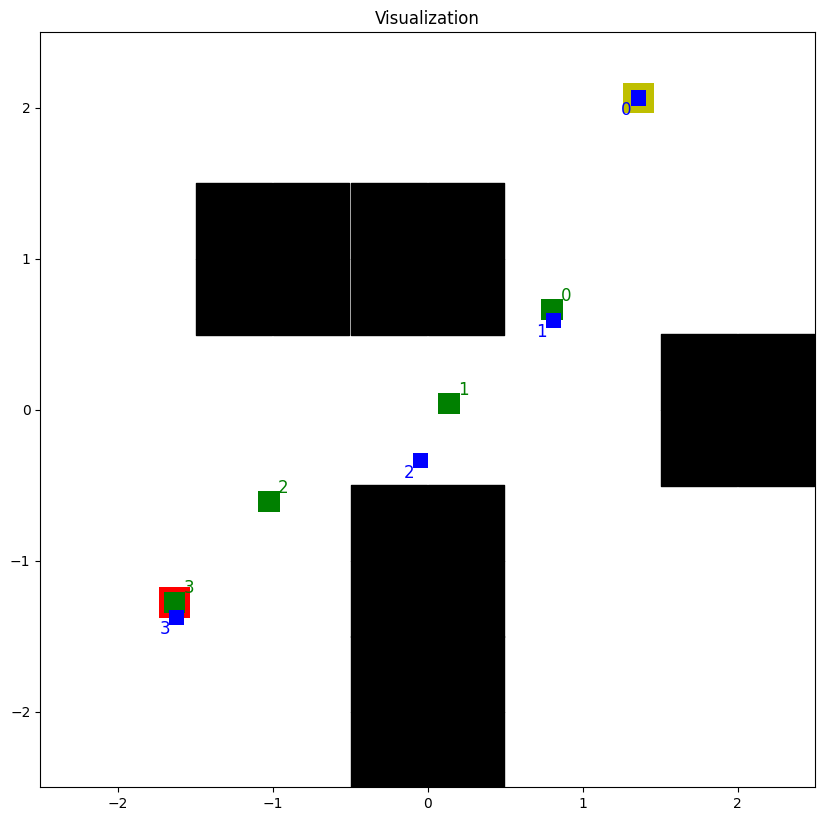

In [33]:
model_cls = MLPCNNModel
dataset_cls = MLPCNNDataset

model = load_feedforward_model(model_cls, "MLPCNN_test2")
idx = np.random.randint(len(test_set))
status, predicted_path, occ_grid, gt_path, col_prop = single_motion_planning_test(
    model, test_set, idx, check_collision=True)
print(f'Status: {status}')
visualize_data(occ_grid, gt_path[0], gt_path[-1], gt_path[1:], predicted_path)
print(col_prop)
# visualize_data(occ_grid, gt_path[0], gt_path[-1], gt_path[1:], planned_path)

2. We test a simple RNN, that takes at each timestep an input consisting of the concatenated goal and current position. The obstacle grid is encoded into the initial hidden state of the RNN using an MLP.

In [85]:
### Motion planning test with RNN ###
# Load data once, so we do not have to load repeatedly
test_set = MLPRNNDataset.load_dataset_from_file(os.path.join(CURRENT_DIR, 'test_dataset/data_path.json'), device=DEVICE)

Loading data from .\test_dataset/data_path.json
dataset size = 377


COLLIDED
Status: COLLIDED


<IPython.core.display.Javascript object>


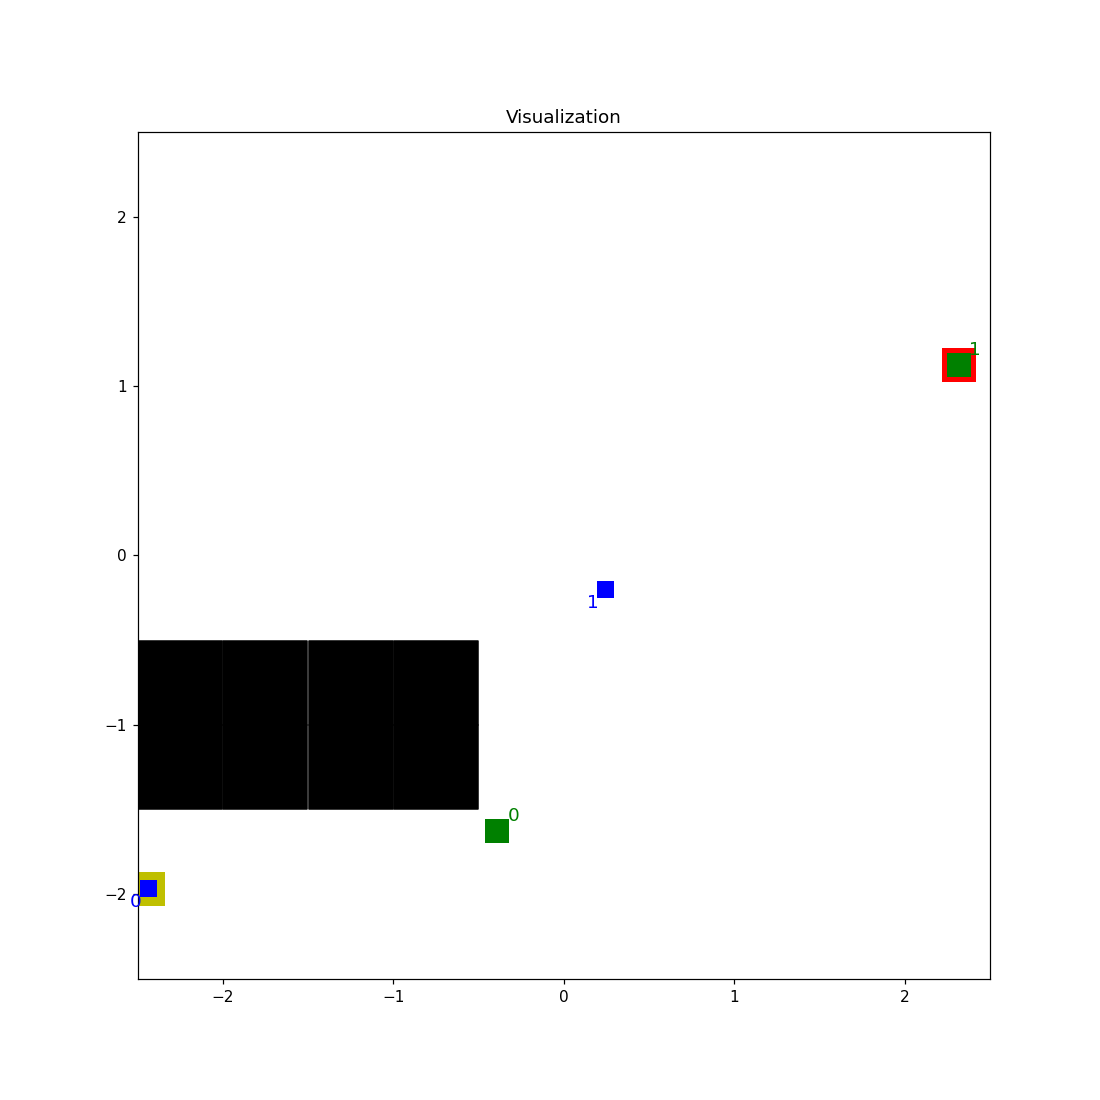

In [239]:
# Select a random test case, perform motion planning with iterative inferences and visualise results
model = load_recurrent_model(MLPRNNModel, "MLPRNN_test4")
idx = np.random.randint(len(test_set))
status, predicted_path, occ_grid, gt_path = single_motion_planning_test(
    model, test_set, idx, is_recurrent=True, check_collision=True, max_iters=10)
print(f'Status: {status}')
visualize_data(occ_grid, gt_path[0], gt_path[-1], gt_path[1:], predicted_path)

### Overall performance on test dataset

We evaluate the performance of our networks at motion planning, over the entire test dataset.

In [36]:
with open(os.path.join(CURRENT_DIR, 'test_dataset/data_path.json')) as _file:
    data = json.load(_file)

In [65]:
### Motion planning test with MLP ###
# Provide the model-specific parameters
model_cls = MLPModel
dataset_cls = MLPDataset

model = load_feedforward_model(MLPModel, "MLP_test3")
success_rate, path_length_ratio = test_over_data(model, data, dataset_cls, number=-1, is_recurrent=False, check_collision=True)
print("Success rate: ", success_rate, " Path length ratio: ", path_length_ratio)

FileNotFoundError: [Errno 2] No such file or directory: './models/MLP_test3.pt'

In [39]:
### Motion planning test with MLP ###
# Provide the model-specific parameters
model_cls = MLPCNNModel
dataset_cls = MLPCNNDataset

model = load_feedforward_model(model_cls, "MLPCNN_test2")
success_rate, path_length_ratio = test_over_data(model, data, dataset_cls, number=-1, is_recurrent=False, check_collision=True)
print("Success rate: ", success_rate, " Path length ratio: ", path_length_ratio)

dataset size = 377
Tested  0
Tested  10
Tested  20
Tested  30
Tested  40
Tested  50
Tested  60
Tested  70
Tested  80
Tested  90
Tested  100
Tested  110
Tested  120
Tested  130
Tested  140
Tested  150
Tested  160
Tested  170
Tested  180
Tested  190
Tested  200
Tested  210
Tested  220
Tested  230
Tested  240
Tested  250
Tested  260
Tested  270
Tested  280
Tested  290
Tested  300
Tested  310
Tested  320
Tested  330
Tested  340
Tested  350
Tested  360
Tested  370
Success rate:  0.6907183272476076  Path length ratio:  1.2961622828918389


In [40]:
### Motion planning test with RNN ###
# Provide the model-specific parameters
model_cls = MLPRNNModel
dataset_cls = MLPRNNDataset

# Evaluate performance on test set
model = load_recurrent_model(MLPRNNModel, "MLPRNN_test4")
success_rate, path_length_ratio = test_over_data(model, data, dataset_cls, number=-1, is_recurrent=True, check_collision=True)
print(success_rate, path_length_ratio)

NameError: name 'MLPRNNModel' is not defined

# Discussion of results

TODO: Summarise the experimental results and provide suggestions for the observed behaviour

# References

[1] P. Anderson, A. Chang, D.S. Chaplot,A.  Dosovitskiy, S. Gupta, V. Koltun, J. Kosecka, J. Malik, R. Mottaghi, M. Savva, A.R. Zamir. On Evaluation of Embodied Navigation Agents. arXiv preprint 1807.06757, 2018